In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train-v0.2.csv")

In [ ]:
mega_table = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/product_catalogue-v0.2.csv")
train= pd.merge(train, mega_table, how = 'left', left_on = ['product_id', 'query_locale'], right_on = ['product_id', 'product_locale'])

EDA

In [ ]:
#LENGTH OF STRING FILTER
train=train.fillna('')
lens = lambda x: len(str(x))
length_train_df = pd.DataFrame()
for name in train.columns:
    if ('product' in name or 'query' in name) and 'locale' not in name:
        length_train_df[f'{name}_length'] = train[name].apply(lens)
round(length_train_df.describe(),2)

,query_length,product_id_length,product_title_length,product_description_length,product_bullet_point_length,product_brand_length,product_color_name_length
count,1834744.00,1834744.0,1834744.00,1834744.00,1834744.00,1834744.00,1834744.00
mean,19.52,10.0,103.33,394.52,559.73,8.84,5.78
std,10.05,0.0,53.79,585.50,517.68,5.85,7.22
min,1.00,10.0,0.00,0.00,0.00,0.00,0.00
25%,12.00,10.0,60.00,0.00,121.00,6.00,0.00
50%,18.00,10.0,94.00,0.00,429.00,7.00,5.00
75%,25.00,10.0,148.00,667.00,888.00,11.00,8.00
max,165.00,10.0,400.00,8640.00,2503.00,100.00,100.00


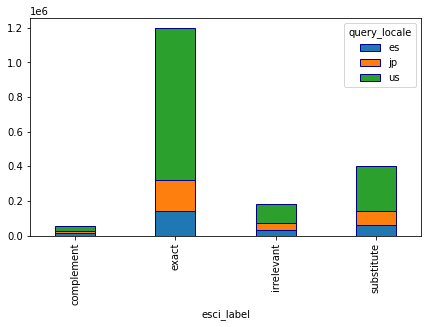

In [ ]:
#Label count
pd.crosstab(train.esci_label,train.query_locale).plot.bar(stacked=True,figsize=(7,4),width = 0.4,edgecolor = 'darkblue', lw=1)
# plt.xticks(rotation=0,size='large')
# plt.legend(bbox_to_anchor=(0.55,0.9))


  0%|          | 0/200000 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors


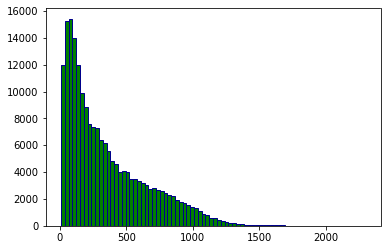

In [ ]:
# Token Length In A PreTrained Model
## use bert-base-multilingual-cased as example
import pandas as pd
from tqdm.notebook import tqdm
! pip install transformers
from transformers import AutoTokenizer, AutoModel, TFAutoModel, pipeline
import matplotlib.pylab as plt
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')
df = train.sample(200000,random_state= 2022)
token_len = []
bar = tqdm(df.iterrows(),total=df.shape[0])
for i, row in bar:
    text = [row['query'], row['product_title'], row['product_bullet_point'], row['product_brand'],
            row['product_color_name'], row['product_locale'], row['product_description']]
    text = [str(i) for i in text]
    text = f' {tokenizer.sep_token} '.join(text)
    encoded_text = tokenizer.encode_plus(text, add_special_tokens=False)
    input_ids = encoded_text["input_ids"]
    token_len.append(len(input_ids))

plt.hist(token_len,bins=80,color='green',edgecolor = 'darkblue', lw=1)
plt.show()

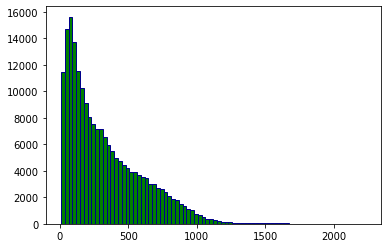

In [ ]:
import re
import pandas as pd
from tqdm.notebook import tqdm
! pip install transformers
from transformers import AutoTokenizer, AutoModel, TFAutoModel, pipeline
import matplotlib.pylab as plt
df = train.sample(200000,random_state= 2022)
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')
def cleanText(text):
    pattern = re.compile(r'<[^>]+>',re.S)
    text = pattern.sub('', text)
    return text

token_len = []
bar = tqdm(df.iterrows(),total=df.shape[0])
for i, row in bar:
    text = [row['query'], row['product_title'], row['product_bullet_point'], row['product_brand'],
            row['product_color_name'], row['product_locale'], row['product_description']]
    text = [cleanText(str(i)) for i in text]
    text = f' {tokenizer.sep_token} '.join(text)
    encoded_text = tokenizer.encode_plus(text, add_special_tokens=False)
    input_ids = encoded_text["input_ids"]
    token_len.append(len(input_ids))

plt.hist(token_len,bins=80,color='green',edgecolor = 'darkblue', lw=1)
plt.show()

Feature engineering

In [ ]:
def is_included_in_title(row):
  return int(row['query'].lower() in row['product_title'].lower())
    
def is_included_in_description(row):
  return int(row['query'].lower() in row['product_description'].lower())

def is_included_in_bullet_point(row):
  return int(row['query'].lower() in row['product_bullet_point'].lower())

def is_included_in_brand(row):
  return int(row['query'].lower() in row['product_brand'].lower())
    
def is_included_in_color_name(row):
  return int(row['query'].lower() in row['product_color_name'].lower())

def is_included_in_any(row):
  return row['is_included_in_title'] or row['is_included_in_description'] or row['is_included_in_bullet_point'] or row['is_included_in_brand'] or row['is_included_in_color_name']

In [ ]:
train['is_included_in_title'] = train.apply(is_included_in_title, axis=1)
train['is_included_in_description'] = train.apply(is_included_in_description, axis=1)
train['is_included_in_bullet_point'] = train.apply(is_included_in_bullet_point, axis=1)
train['is_included_in_brand'] = train.apply(is_included_in_brand, axis=1)
train['is_included_in_color_name'] = train.apply(is_included_in_color_name, axis=1)

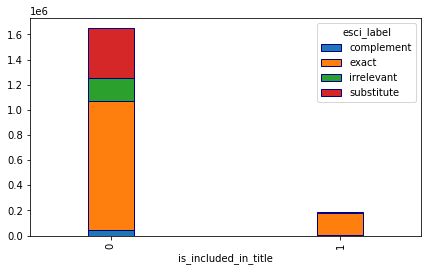

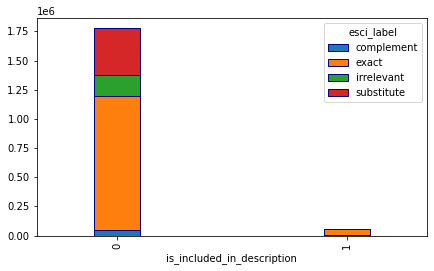

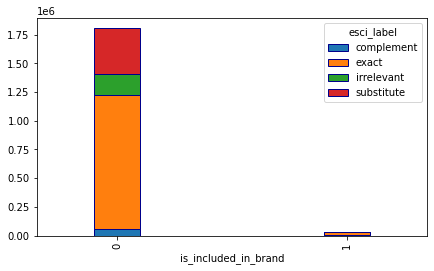

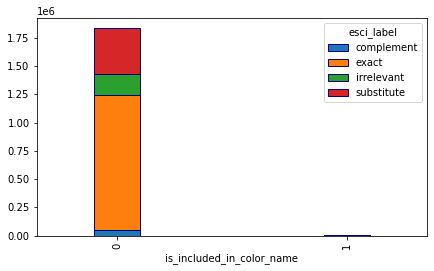

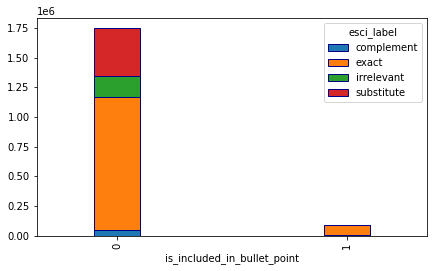

In [ ]:
#Label count
import matplotlib.pylab as plt


pd.crosstab(train.is_included_in_title,train.esci_label).plot.bar(stacked=True,figsize=(7,4),width = 0.2,edgecolor = 'darkblue', lw=1)



pd.crosstab(train.is_included_in_description,train.esci_label).plot.bar(stacked=True,figsize=(7,4),width = 0.2,edgecolor = 'darkblue', lw=1)


pd.crosstab(train.is_included_in_brand,train.esci_label).plot.bar(stacked=True,figsize=(7,4),width = 0.2,edgecolor = 'darkblue', lw=1)



pd.crosstab(train.is_included_in_color_name,train.esci_label).plot.bar(stacked=True,figsize=(7,4),width = 0.2,edgecolor = 'darkblue', lw=1)


pd.crosstab(train.is_included_in_bullet_point,train.esci_label).plot.bar(stacked=True,figsize=(7,4),width = 0.2,edgecolor = 'darkblue', lw=1)
